In [3]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image as tf_image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib
import gc

/Users/vince_carter420/Documents/RiceSafe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# --- SETTINGS ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_IMG_DIR = 'data/train_image/'
TEST_IMG_DIR = 'data/test_image/'
TRAIN_TEXT_DIR = 'data/train_text/'
TEST_TEXT_DIR = 'data/test_text/'
SAVE_MODEL_PATH = 'RiceSafeModel.keras'
LABEL_ENCODER_PATH = 'label_encoder.pkl'
SCALER_PATH = 'scaler.pkl'

In [5]:
DISEASE_CLASSES = ['ปกติ', 'โรคขอบใบแห้ง', 'โรคใบขีดโปร่งแสง', 'โรคใบจุดสีน้ำตาล', 'โรคไหม้']

In [6]:
# --- IMAGE PROCESSING ---
def load_image(img_path):
    try:
        img = tf_image.load_img(img_path, target_size=(224, 224))
        img_array = tf_image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 224, 224, 3)
        return preprocess_input(img_array)
    except Exception as e:
        print(f"[ERROR] Failed to load {img_path}: {e}")
        return None

In [7]:
# --- TEXT EMBEDDING ---
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-m3")
text_model = AutoModel.from_pretrained("BAAI/bge-m3").to(DEVICE).eval()

@torch.no_grad()
def embed_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(DEVICE)
    outputs = text_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

In [8]:
# --- IMAGE FEATURE EXTRACTOR ---
mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
mobilenet.trainable = False

def extract_img_feature(img_array):
    if isinstance(img_array, list):
        img_array = np.vstack(img_array)
    features = mobilenet.predict(img_array)
    return features

/var/folders/dq/b3nl28f51bsblfk_lyn94j240000gn/T/ipykernel_17471/503381850.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


In [9]:
# --- MAIN PAIRING FUNCTION ---
def pair_images_and_texts(batch_size=32):
    paired_data = []

    for disease_class in os.listdir(TRAIN_IMG_DIR):
        img_folder = os.path.join(TRAIN_IMG_DIR, disease_class)
        text_file = os.path.join(TRAIN_TEXT_DIR, f"{disease_class}.csv")

        if not os.path.isdir(img_folder) or not os.path.isfile(text_file):
            print(f"[SKIP] {disease_class}: Folder or CSV not found.")
            continue

        image_files = sorted([
            f for f in os.listdir(img_folder)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        df_text = pd.read_csv(text_file)
        text_lines = df_text.iloc[:, 0].tolist()

        if len(image_files) != len(text_lines):
            print(f"[WARNING] Mismatch in {disease_class}: {len(image_files)} images vs {len(text_lines)} texts")
            continue

        for i in range(0, len(image_files), batch_size):
            batch_imgs = []
            batch_texts = []

            for img_name, text in zip(image_files[i:i+batch_size], text_lines[i:i+batch_size]):
                img_path = os.path.join(img_folder, img_name)
                img_array = load_image(img_path)
                if img_array is not None:
                    batch_imgs.append(img_array)
                    batch_texts.append(text)

            if batch_imgs and batch_texts:
                img_feats = extract_img_feature(np.vstack(batch_imgs))
                text_feats = embed_text(batch_texts)
                paired_data.extend([
                    (np.concatenate((img_feat, text_feat)), disease_class)
                    for img_feat, text_feat in zip(img_feats, text_feats)
                ])


            gc.collect()

    return paired_data

In [10]:
# --- FINALIZE TRAINING FEATURES ---
# print("[*] Pairing images and texts...")
paired_data = pair_images_and_texts(batch_size=32)
# print(f"[DONE] Paired {len(paired_data)} image-text entries.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 935ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[SKIP] .DS_Store: Folder or CSV not found.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


In [11]:
if not paired_data:
    print("[!] No training data found.")
    exit(1)

for i, entry in enumerate(paired_data):
    if not isinstance(entry, tuple) or len(entry) != 2:
        print(f"[!] Invalid entry at index {i}: {entry}")

# --- SPLIT FEATURES AND LABELS ---
features, labels = zip(*paired_data)
X = np.array(features)
y = np.array(labels)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [12]:
# --- FEATURE SCALING ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
joblib.dump(scaler, SCALER_PATH)

# --- LABELS ENCODING ---
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
joblib.dump(le, LABEL_ENCODER_PATH)

['label_encoder.pkl']

In [13]:
# --- DEFINE NEURAL NETWORK ---
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(DISEASE_CLASSES), activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint(SAVE_MODEL_PATH, save_best_only=True, monitor='val_accuracy')
]

In [14]:
# --- TRAIN MODEL ---
# Training
history = model.fit(
    X_train_scaled, y_train_categorical,
    validation_data=(X_val_scaled, y_val_categorical),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)
# --- SAVE MODEL & ENCODER ---
model.save(SAVE_MODEL_PATH)
joblib.dump(le, LABEL_ENCODER_PATH)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3111 - loss: 1.9916 - val_accuracy: 0.7147 - val_loss: 0.7614 - learning_rate: 1.0000e-04
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7495 - loss: 0.7312 - val_accuracy: 0.8853 - val_loss: 0.4208 - learning_rate: 1.0000e-04
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8788 - loss: 0.3963 - val_accuracy: 0.9493 - val_loss: 0.2748 - learning_rate: 1.0000e-04
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9224 - loss: 0.2535 - val_accuracy: 0.9627 - val_loss: 0.1993 - learning_rate: 1.0000e-04
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9572 - loss: 0.2016 - val_accuracy: 0.9680 - val_loss: 0.1562 - learning_rate: 1.0000e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9741 - loss: 0.1539 - val_accuracy: 0.9787 - val_loss: 0.1269 - learning_rate: 1.0000e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.980

['label_encoder.pkl']

In [15]:
val_loss, val_acc = model.evaluate(X_val_scaled, y_val_categorical, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0096
Validation Accuracy: 0.9947
Validation Loss: 0.0178


In [16]:
val_predictions = model.predict(X_val_scaled)
val_predicted_labels = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(y_val_categorical, axis=1)

val_report = classification_report(val_true_labels, val_predicted_labels,
                                   target_names=DISEASE_CLASSES)
print(val_report)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
                  precision    recall  f1-score   support

            ปกติ       1.00      1.00      1.00        75
    โรคขอบใบแห้ง       1.00      1.00      1.00        75
โรคใบขีดโปร่งแสง       1.00      1.00      1.00        75
โรคใบจุดสีน้ำตาล       1.00      0.97      0.99        75
         โรคไหม้       0.97      1.00      0.99        75

        accuracy                           0.99       375
       macro avg       0.99      0.99      0.99       375
    weighted avg       0.99      0.99      0.99       375



In [17]:
# --- MAIN PAIRING FUNCTION ---
def pair_test_images_and_texts(batch_size=32):
    test_paired_data = []

    for test_disease_class in os.listdir(TEST_IMG_DIR):
        test_img_folder = os.path.join(TEST_IMG_DIR, test_disease_class)
        test_text_file = os.path.join(TEST_TEXT_DIR, f"{test_disease_class}.csv")

        if not os.path.isdir(test_img_folder) or not os.path.isfile(test_text_file):
            print(f"[SKIP] {test_disease_class}: Folder or CSV not found.")
            continue

        test_image_files = sorted([
            f for f in os.listdir(test_img_folder)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        test_df_text = pd.read_csv(test_text_file)
        test_text_lines = test_df_text.iloc[:, 0].tolist()

        if len(test_image_files) != len(test_text_lines):
            print(f"[WARNING] Mismatch in {test_disease_class}: {len(test_image_files)} images vs {len(test_text_lines)} texts")
            continue

        for i in range(0, len(test_image_files), batch_size):
            batch_test_imgs = []
            batch_test_texts = []

            for img_name, text in zip(test_image_files[i:i+batch_size], test_text_lines[i:i+batch_size]):
                img_path = os.path.join(test_img_folder, img_name)
                img_array = load_image(img_path)
                if img_array is not None:
                    batch_test_imgs.append(img_array)
                    batch_test_texts.append(text)

            if batch_test_imgs and batch_test_texts:
                test_img_feats = extract_img_feature(np.vstack(batch_test_imgs))
                test_text_feats = embed_text(batch_test_texts)
                test_paired_data.extend([
                    (np.concatenate((img_feat, text_feat)), test_disease_class)
                    for img_feat, text_feat in zip(test_img_feats, test_text_feats)
                ])

            gc.collect()

    return test_paired_data

In [18]:
# --- FINALIZE TEST FEATURES ---
test_paired_data = pair_test_images_and_texts(batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


In [19]:
# --- PREPARE TEST DATA ---
if not test_paired_data:
    print("[ERROR] No test data was paired successfully.")
    exit(1)

# Split test data into features and labels
test_features_raw, test_labels_raw = zip(*test_paired_data)
X_test = np.array(test_features_raw)
y_test = np.array(test_labels_raw)

# Load the scaler and label encoder
scaler = joblib.load(SCALER_PATH)
le = joblib.load(LABEL_ENCODER_PATH)

# Preprocess test data
X_test_scaled = scaler.transform(X_test)
y_test_encoded = le.transform(y_test)
y_test_categorical = to_categorical(y_test_encoded)

In [20]:
# --- LOAD THE SAVED MODEL ---
model = load_model(SAVE_MODEL_PATH)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# --- EVALUATE ON TEST SET ---
# Get loss and accuracy
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_categorical, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9491 - loss: 0.1673  

Test Accuracy: 0.9484
Test Loss: 0.1648


In [22]:
predictions = model.predict(X_test_scaled)
predicted_labels = np.argmax(predictions, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [23]:
# Classification Report
report = classification_report(y_test_encoded, predicted_labels,
                              target_names=DISEASE_CLASSES)
report

'                  precision    recall  f1-score   support\n\n            ปกติ       1.00      1.00      1.00        62\n    โรคขอบใบแห้ง       1.00      1.00      1.00        62\nโรคใบขีดโปร่งแสง       1.00      0.98      0.99        62\nโรคใบจุดสีน้ำตาล       0.89      0.87      0.88        62\n         โรคไหม้       0.86      0.89      0.87        62\n\n        accuracy                           0.95       310\n       macro avg       0.95      0.95      0.95       310\n    weighted avg       0.95      0.95      0.95       310\n'

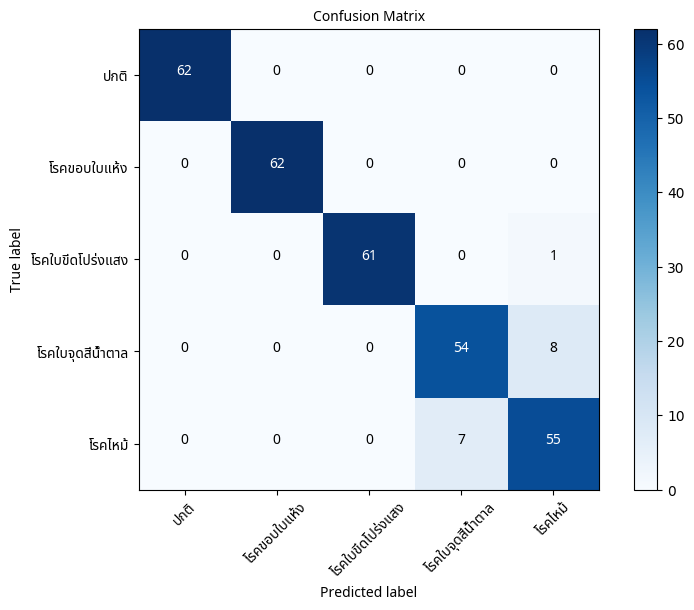

In [24]:
# --- VISUALIZE RESULTS ---
font_path = 'fonts/NotoSansThai-VariableFont_wdth,wght.ttf'
thai_font = fm.FontProperties(fname=font_path)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontproperties=thai_font)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    # Use Thai font for tick labels
    plt.xticks(tick_marks, classes, rotation=45, fontproperties=thai_font)
    plt.yticks(tick_marks, classes, fontproperties=thai_font)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j]:.2f}' if normalize else cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontproperties=thai_font)

    plt.tight_layout()
    plt.ylabel('True label', fontproperties=thai_font)
    plt.xlabel('Predicted label', fontproperties=thai_font)
    plt.show()

cm = confusion_matrix(y_test_encoded, predicted_labels)
plot_confusion_matrix(cm, DISEASE_CLASSES)

In [25]:
print(cm)

[[62  0  0  0  0]
 [ 0 62  0  0  0]
 [ 0  0 61  0  1]
 [ 0  0  0 54  8]
 [ 0  0  0  7 55]]


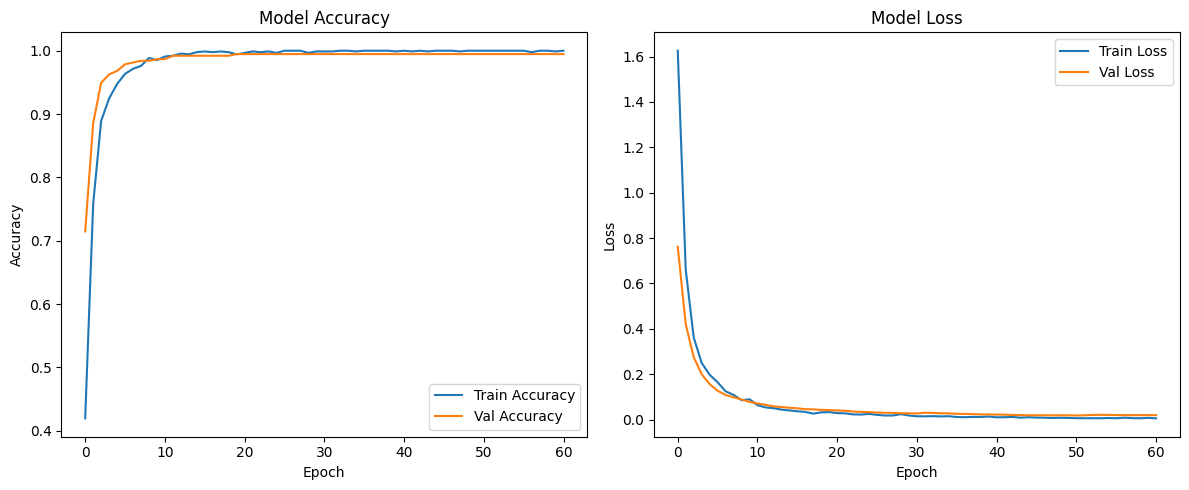

In [26]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
def permutation_importance_modality(model, X_val, y_val, metric=accuracy_score, image_dim=1024, text_dim=768, n_repeats=5):
    baseline_score = metric(y_val, np.argmax(model.predict(X_val), axis=1))

    importances = {}

    for name, start, end in [("Image", 0, image_dim), ("Text", image_dim, image_dim + text_dim)]:
        scores = []
        for _ in range(n_repeats):
            X_permuted = X_val.copy()
            idx = np.arange(start, end)
            np.random.shuffle(idx)
            X_permuted[:, start:end] = X_val[:, idx]
            score = metric(y_val, np.argmax(model.predict(X_permuted), axis=1))
            scores.append(baseline_score - score)
        importances[name] = np.mean(scores)

    return importances

NameError: name 'accuracy_score' is not defined

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step


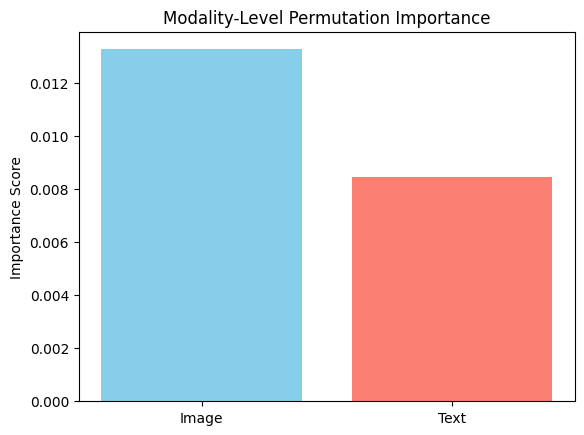

Image Importance: 0.0133
Text Importance: 0.0085


In [42]:
from sklearn.metrics import accuracy_score

importances = permutation_importance_modality(model, X_train_scaled, y_train_encoded)

plt.bar(importances.keys(), importances.values(), color=['skyblue', 'salmon'])
plt.title("Modality-Level Permutation Importance")
plt.ylabel("Importance Score")
plt.show()

for modality, score in importances.items():
    print(f"{modality} Importance: {score:.4f}")